In [0]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import numpy as np
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label

data_dir = './'

In [0]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

In [0]:
# Read in cars and notcars image paths
car_paths = glob.glob(data_dir + '/data/vehicles/**/*.png', recursive=True)
notcar_paths = glob.glob(data_dir + '/data/non-vehicles/**/*.png', recursive=True)

# Read car images
cars=[]
for path in car_paths:
    car = read_image(path)
    cars.append(car)

notcars=[]
for path in notcar_paths:
    notcar = read_image(path)
    notcars.append(notcar)
    
print('Number of cars = ', len(cars))
print('Number of Non cars = ', len(notcars))

Number of cars =  8792
Number of Non cars =  8968


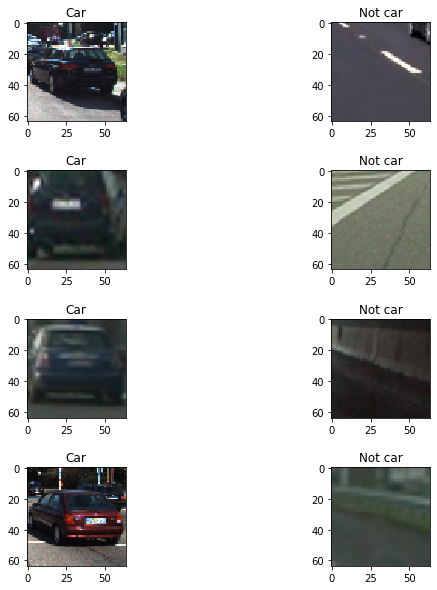

In [0]:
# Visualize the dataset
fig, axes = plt.subplots(4,2, figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
for i in range(4):
    car_num = np.random.randint(len(cars)-1)
    notcar_num = np.random.randint(len(notcars)-1)
    axes[i, 0].imshow(cars[car_num])
    axes[i, 0].set_title('Car')
    axes[i, 1].imshow(notcars[notcar_num])
    axes[i, 1].set_title('Not car')
plt.show()

In [0]:
def get_color_space(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'BGR':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        elif color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    return feature_image

def color_hist(feature_image, nbins=32, bins_range=(0, 256)):
    '''
    Extract color features from the image
    params:
        img: image
        nbins: number of bins for the histogram
        bins_range: range of the channel spectrum
    return:
        hist_features: histogram features
    '''
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(feature_image[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(feature_image[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(feature_image[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Get centers
    edges = channel1_hist[1]
    centers = (edges[1:] + edges[0:len(edges)-1])/2
    # Return the individual histograms, bin_centers and feature vector
    return hist_features, channel1_hist, channel2_hist, channel3_hist, centers


Histogram features =  96


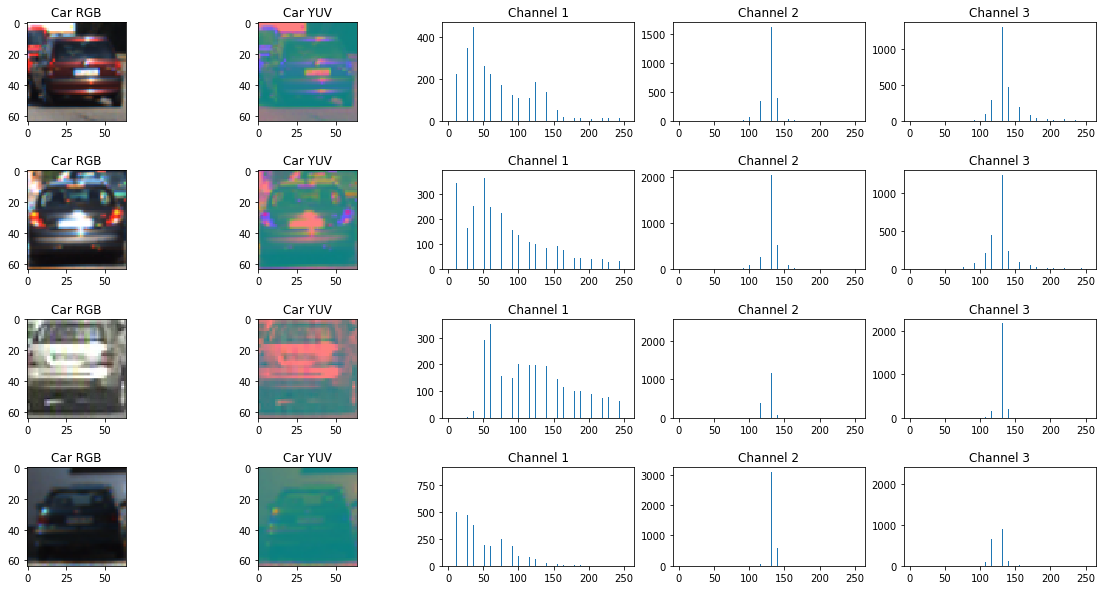

In [0]:
# Color features for vehicle
f, axes= plt.subplots(4,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)
for idx in range(4):
    car_num = np.random.randint(len(cars)-1)
    car_img = cars[car_num]

    car_cspace = get_color_space(car_img, color_space='YUV')
    feature_vec, ch1, ch2, ch3, bincen  = color_hist(car_cspace)

    axes[idx,0].imshow(car_img)
    axes[idx,0].set_title('Car RGB')
    axes[idx,1].imshow(car_cspace)
    axes[idx,1].set_title('Car YUV')
    axes[idx,2].bar(bincen,ch1[0])
    axes[idx,2].set_title('Channel 1')
    axes[idx,3].bar(bincen,ch2[0])
    axes[idx,3].set_title('Channel 2')
    axes[idx,4].bar(bincen,ch3[0])
    axes[idx,4].set_title('Channel 3')

print('Histogram features = ', len(feature_vec))

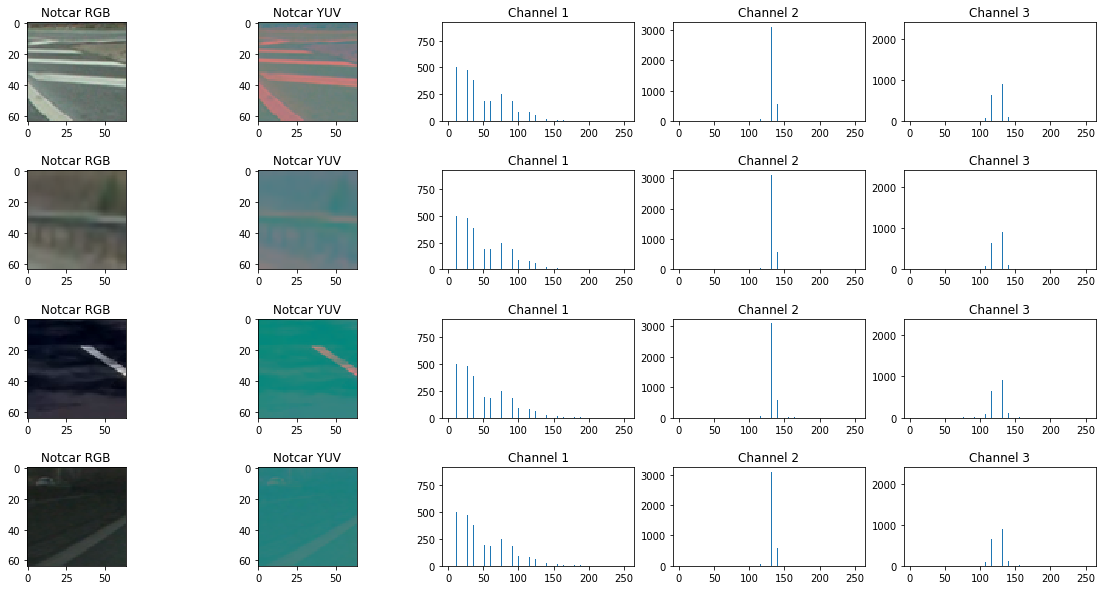

In [0]:
# Color features for non-cars
f, axes= plt.subplots(4,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)
for idx in range(4):
    notcar_num = np.random.randint(len(notcars)-1)
    notcar_img = notcars[notcar_num]

    notcar_cspace = get_color_space(notcar_img, color_space='YUV')
    feature_vec, ch1, ch2, ch3, bincen  = color_hist(car_cspace)

    axes[idx,0].imshow(notcar_img)
    axes[idx,0].set_title('Notcar RGB')
    axes[idx,1].imshow(notcar_cspace)
    axes[idx,1].set_title('Notcar YUV')
    axes[idx,2].bar(bincen,ch1[0])
    axes[idx,2].set_title('Channel 1')
    axes[idx,3].bar(bincen,ch2[0])
    axes[idx,3].set_title('Channel 2')
    axes[idx,4].bar(bincen,ch3[0])
    axes[idx,4].set_title('Channel 3')

In [0]:
# Resize the image to decrease the feature vector size
def bin_spatial(img, size=(32, 32)):
    image = cv2.resize(img, size)
    feats = image.ravel()
    return feats

In [0]:
img = cars[100]
spatial_feats= bin_spatial(img)
print('Number of features before binning = ', len(img.ravel()))
print('Number of features after binning = ', len(spatial_feats))

Number of features before binning =  12288
Number of features after binning =  3072


In [0]:
# HOG features
def hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Number of features per channel =  49


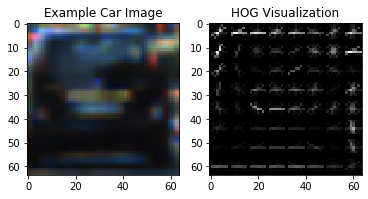

In [0]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = cars[ind]
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

print('Number of features per channel = ', len(np.concatenate(features)))

In [0]:
def single_image_features(img, spatial_size=(32, 32),
                        hist_bins=32, bins_range=(0,256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    '''
    Combines the desired features
    params:
        img: Image
        color_space: Color space from which we would like to extract the color (histogram) features
        spatial_size: size required in 
        hist_bins
        orient: number of orientation directions
        pix_per_cell: pixels to be included in a  particular cell
        cell_per_block: 2d tuple for getting cells in x & y directions
        vis: Visualization image
        feature_vec: feature vector
    '''
    
    features = []
    if spatial_feat:
        feats = bin_spatial(img, spatial_size)
        features.append(feats)
    if hist_feat:
        feats, channel1_hist, channel2_hist, channel3_hist, centers= color_hist(img, hist_bins, bins_range)
        features.append(feats)
    if hog_feat:
        hog_feats = []
        if hog_channel == 'All':           
            for channel in range(img.shape[2]):
                feats, hog_img = hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                hog_feats.extend(feats)
        else:
            img_channel = img[:,:,hog_channel]
            feats, hog_img = hog_features(img_channel, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            hog_feats.extend(feats)
        features.append(hog_feats)
        
    return np.concatenate(features)

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for img in imgs:
        image = get_color_space(img, color_space)
        image_features = single_image_features(image, spatial_size=spatial_size,
                                               hist_bins=hist_bins, orient=orient, 
                                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                               spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(image_features)

    return features

In [0]:
class Args():
    color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 0 # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
args = Args()


In [0]:
# Extract features 
car_features = extract_features(cars, color_space=args.color_space, 
                                spatial_size=args.spatial_size, hist_bins=args.hist_bins, 
                                orient=args.orient, pix_per_cell=args.pix_per_cell, 
                                cell_per_block=args.cell_per_block, 
                                hog_channel=args.hog_channel, spatial_feat=args.spatial_feat, 
                                hist_feat=args.hist_feat, hog_feat=args.hog_feat)
notcar_features = extract_features(notcars, color_space=args.color_space, 
                                spatial_size=args.spatial_size, hist_bins=args.hist_bins, 
                                orient=args.orient, pix_per_cell=args.pix_per_cell, 
                                cell_per_block=args.cell_per_block, 
                                hog_channel=args.hog_channel, spatial_feat=args.spatial_feat, 
                                hist_feat=args.hist_feat, hog_feat=args.hog_feat)

print('Features collected')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print('Number of exaples = ', len(X))
print('Number of features per example = ', len(X[0]))

Features collected
Number of exaples =  17760
Number of features per example =  2580


In [0]:
# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',args.orient,'orientations',args.pix_per_cell,
    'pixels per cell and', args.cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(max_iter=10000)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
177.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9823


In [0]:
import pickle
dict_pickle = {}
dict_pickle["svc"] = svc
dict_pickle["X_scaler"] = X_scaler
pickle.dump( dict_pickle, open( "training.p", "wb" ) )

'''
with open('training.p', 'rb') as f:
    dict_pickle = pickle.load(f)
svc = dict_pickle["svc"] 
X_scaler = dict_pickle["X_scaler"]
'''



'\nwith open(\'training.p\', \'rb\') as f:\n    dict_pickle = pickle.load(f)\nsvc = dict_pickle["svc"] \nX_scaler = dict_pickle["X_scaler"]\n'

In [0]:
def draw_boxes(img, box_list, color=(255,0,0), thick=6):
    '''
    Draws reactangular boxes as per the co-ordinates given
    params: 
        img: Image on which boxes are to be drawn
        box_list: Co-ordinates of point 1 (upper left corner) and point 2(diametrically opposite point)
        color: Color of the boxes
        thick: thickness of the box lines
    '''
    # Copy the image
    draw_img = np.copy(img)
    # Iterate though the list and draw the boxes
    for box in box_list:
        cv2.rectangle(draw_img, box[0], box[1], color, thick)
    return draw_img

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x_start_stop is not defined, set them to origin of the image
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Calculate number of pixels per stride
    x_pixel_strides = np.int(xy_window[0]*(1-xy_overlap[0]))
    y_pixel_strides = np.int(xy_window[1]*(1-xy_overlap[1]))
    
    # Buffer pixels at the last windows (these wont be shared with any other windows
    x_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    y_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    
    # Calculate number of windows in x and y directions
    x_windows = np.int((xspan-x_buffer)/x_pixel_strides)
    y_windows = np.int((yspan-y_buffer)/y_pixel_strides)
    # Windows list
    windows = []
    
    for y_window in range(y_windows):
        for x_window in range(x_windows):
            start_x = x_window * x_pixel_strides + x_start_stop[0]
            end_x = start_x + xy_window[0]
            start_y = y_window * y_pixel_strides + y_start_stop[0]
            end_y = start_y + xy_window[1]
            windows.append(((start_x, start_y), (end_x, end_y)))
    return windows

In [0]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    # Empty list to store the positively identified windows
    pos_windows = []
    for window in windows:
        # Extract the window from the image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #plt.imshow(test_img)
        image = get_color_space(test_img, color_space)
        image_features = single_image_features(image, spatial_size=spatial_size,
                                               hist_bins=hist_bins, orient=orient, 
                                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                               spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        #print(image_features.shape)
        test_feats = np.array((image_features).reshape(1,-1))
        
        # Scale the features as given by 'scaler' parameter
        scaled_feats = scaler.transform(test_feats)
        # Predict the class of the test_img
        prediction = clf.predict(scaled_feats)
        if prediction == 1:
            #print(prediction)
            pos_windows.append(window)
    return pos_windows
    

8


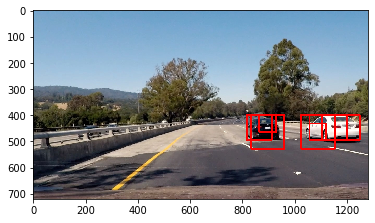

In [0]:
image = read_image(data_dir + 'test_images/test4.jpg')
draw_image = np.copy(image)

windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 600], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 650], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, None], 
                    xy_window=(256, 256), xy_overlap=(0.5, 0.5))

windows = windows1 + windows2 + windows3 + windows4

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=args.color_space, 
                        spatial_size=args.spatial_size, hist_bins=args.hist_bins, 
                        orient=args.orient, pix_per_cell=args.pix_per_cell, 
                        cell_per_block=args.cell_per_block, 
                        hog_channel=args.hog_channel, spatial_feat=args.spatial_feat, 
                        hist_feat=args.hist_feat, hog_feat=args.hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=5)                    
print(len(hot_windows))
plt.imshow(window_img)

In [0]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


In [0]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



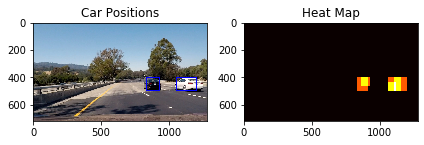

In [0]:
heat = np.zeros_like(window_img[:,:,0])

# Add heat to each box in box list
heat = add_heat(heat, hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [0]:
def get_multiscale_windows(image):
    windows=[]
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 600], 
                            xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 650], 
                            xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
                            xy_window=(128, 128), xy_overlap=(0.5, 0.5))
    windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, None], 
                            xy_window=(256, 256), xy_overlap=(0.5, 0.5))
    #windows.append(windows4)
    windows = windows1 + windows2 + windows3 + windows4
    return windows

In [0]:
def pipeline(image):
    
    windows = get_multiscale_windows(image)
            
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=args.color_space, 
                        spatial_size=args.spatial_size, hist_bins=args.hist_bins, 
                        orient=args.orient, pix_per_cell=args.pix_per_cell, 
                        cell_per_block=args.cell_per_block, 
                        hog_channel=args.hog_channel, spatial_feat=args.spatial_feat, 
                        hist_feat=args.hist_feat, hog_feat=args.hog_feat)                     
            
    heat = np.zeros_like(image[:,:,0])

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img, heatmap

Number of test images =  8
Time required =  267.3966507911682


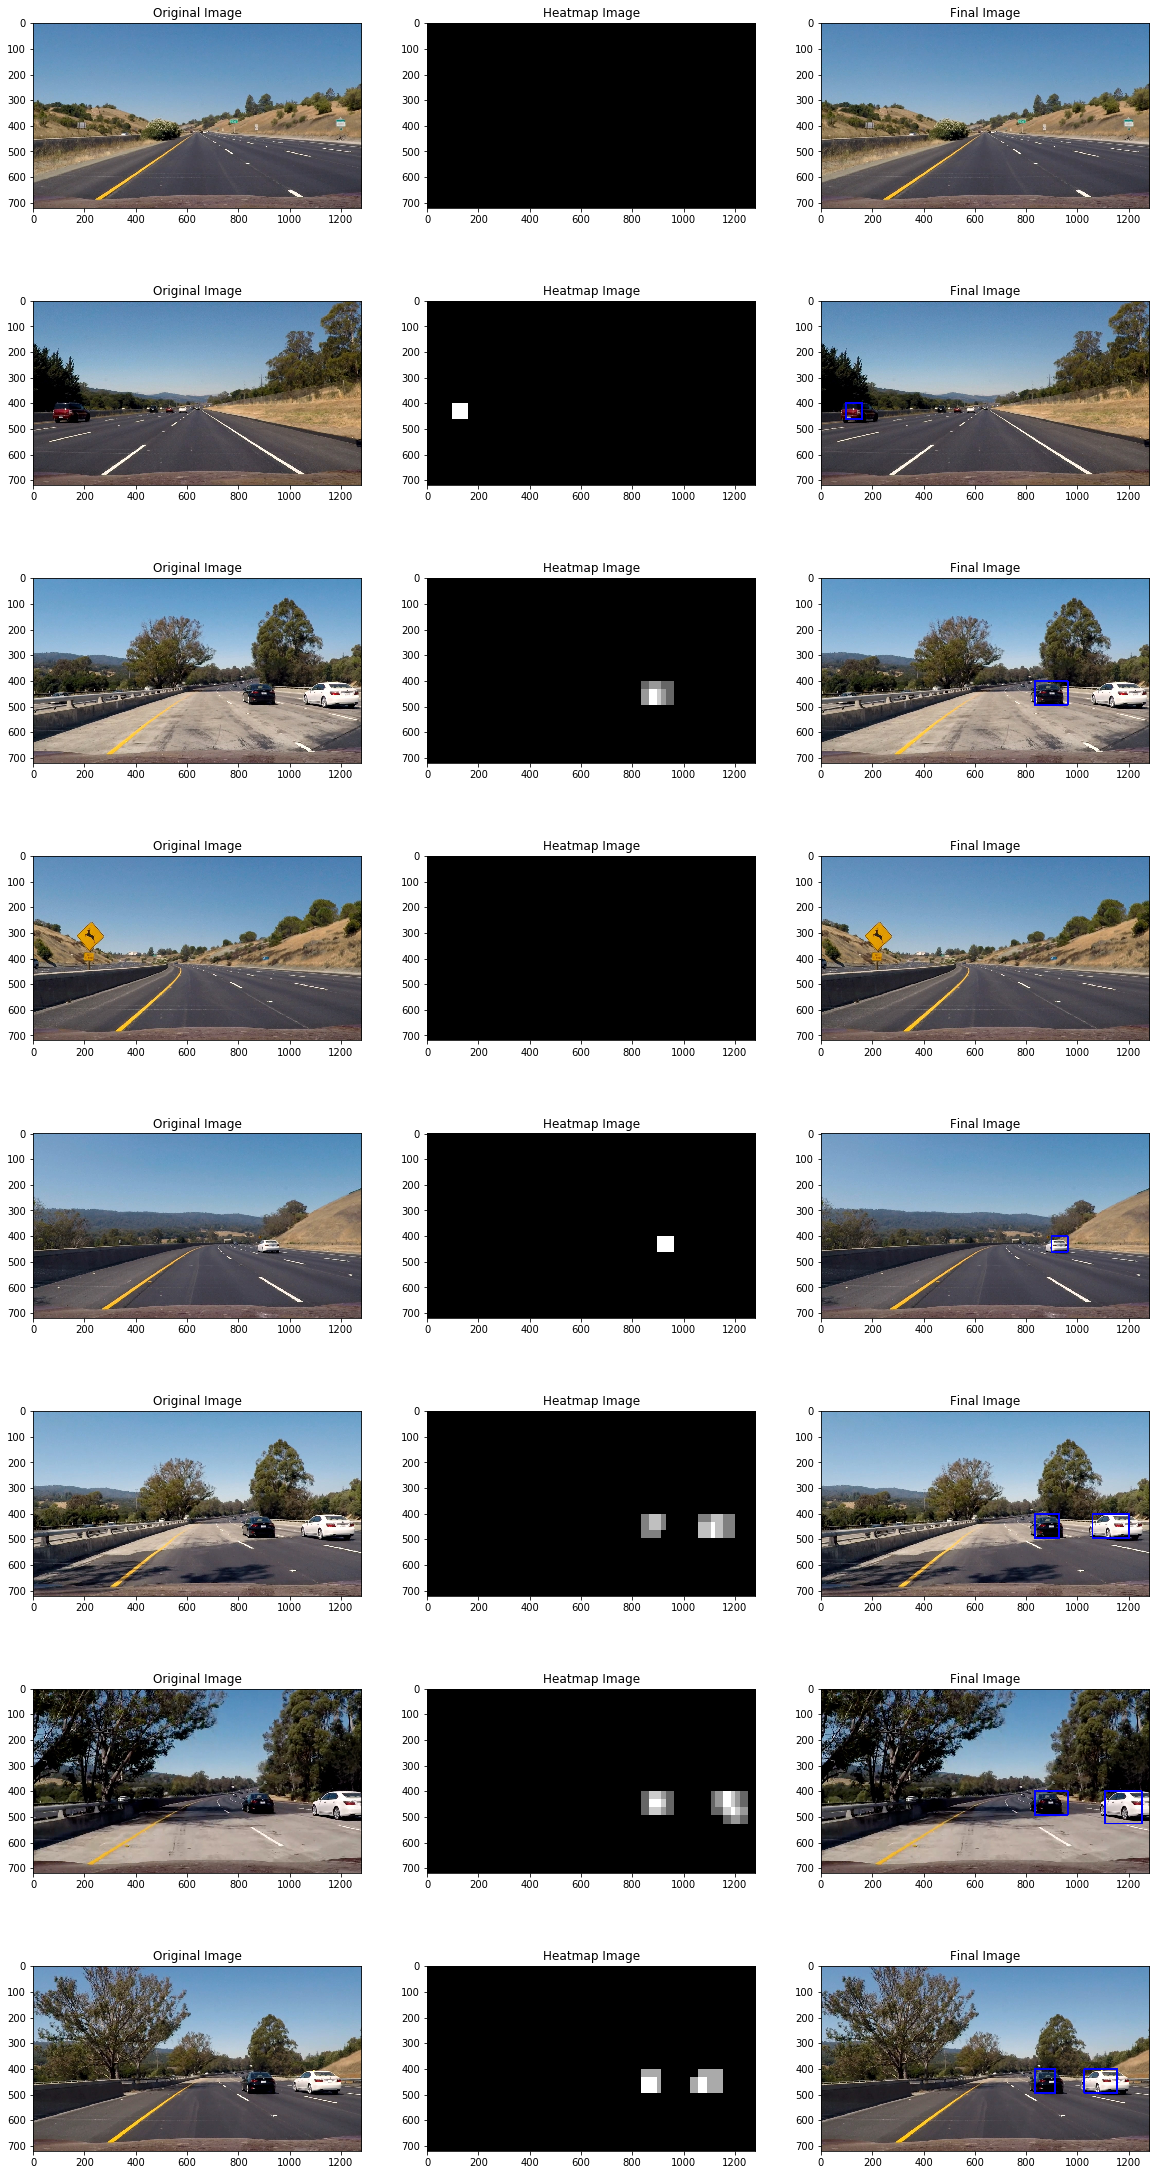

In [0]:
# Results from pipeline
test_images = glob.glob(data_dir + 'test_images/*.jpg')
print('Number of test images = ', len(test_images))
rows = len(test_images)
f, axes= plt.subplots(rows,3, figsize=(20,40))
t=time.time()
for index, image_path in enumerate(test_images):
    write_path = image_path.split('\\')[-1]
    image = mpimg.imread(image_path)
    finalPic,heatmap = pipeline(image)
    axes[index,0].imshow(image)
    axes[index,0].set_title("Original Image")
    axes[index,1].imshow(heatmap,cmap='gray')
    axes[index,1].set_title("Heatmap Image")
    axes[index,2].imshow(finalPic)
    axes[index,2].set_title("Final Image")
t2=time.time()
print('Time required = ', (t2-t))

In [0]:
def find_cars(img, scale, ystart, ystop):
    
    ystart = ystart
    ystop = ystop
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = get_color_space(img_tosearch, args.color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // args.pix_per_cell) - args.cell_per_block + 1
    nyblocks = (ch1.shape[0] // args.pix_per_cell) - args.cell_per_block + 1 
    nfeat_per_block = args.orient*args.cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // args.pix_per_cell) - args.cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    hot_windows=[]
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
                        
            xleft = xpos*args.pix_per_cell
            ytop = ypos*args.pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            #plt.imshow(subimg)
            #plt.show()
            # Get image features
            features = single_image_features(subimg, spatial_size=args.spatial_size,
                                             hist_bins=args.hist_bins, orient=args.orient, 
                                             pix_per_cell=args.pix_per_cell, cell_per_block=args.cell_per_block, hog_channel=args.hog_channel,
                                             spatial_feat=args.spatial_feat, hist_feat=args.hist_feat, hog_feat=args.hog_feat)
            features = np.array(features).reshape(1, -1)

            # Scale features and make a prediction
            test_features = X_scaler.transform(features)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                #print(1)
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                hot_window = (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                hot_windows.append(hot_window)
    return draw_img, hot_windows


Text(0.5, 1.0, 'Final Image')

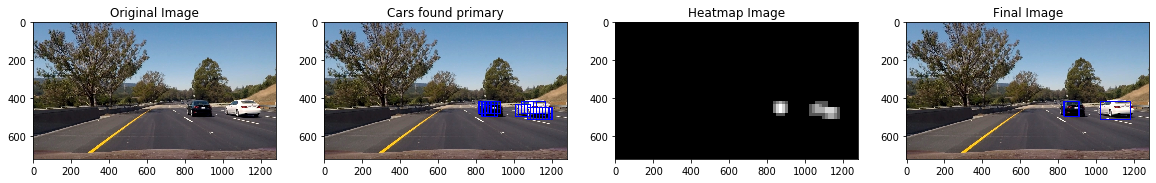

In [0]:
test_img = read_image(data_dir + 'test_images/test6.jpg')
draw_img = np.copy(test_img)

scale=1
ystart, ystop=(400,700)
find_cars_img, hot_windows = find_cars(test_img, scale, ystart, ystop)
heat = np.zeros_like(draw_img[:,:,0])

# Add heat to each box in box list
heat = add_heat(heat, hot_windows)

# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

finalPic = draw_labeled_bboxes(test_img, labels)

f, axes= plt.subplots(1,4, figsize=(20,40))

axes[0].imshow(draw_img)
axes[0].set_title("Original Image")
axes[1].imshow(find_cars_img)
axes[1].set_title("Cars found primary")
axes[2].imshow(heatmap,cmap='gray')
axes[2].set_title("Heatmap Image")
axes[3].imshow(finalPic)
axes[3].set_title("Final Image")

Required time for pipeline_find_cars=  108.04722285270691


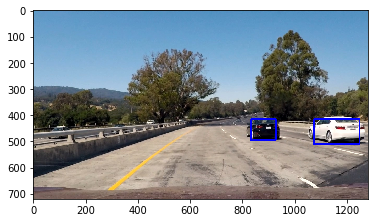

In [0]:
def pipeline_find_cars(image):
    
    draw_image = np.copy(image)
    
    windows = []
    scale, ystart, ystop = (1, 400, 700)
    image, hot_windows = find_cars(image, scale, ystart, ystop)
    windows += hot_windows
    
    heat = np.zeros_like(image[:,:,0])

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    finalPic = draw_labeled_bboxes(draw_image, labels)

    return finalPic

test_img = read_image(data_dir + 'test_images/test1.jpg')
t = time.time()
draw_img = pipeline_find_cars(test_img)
t2 = time.time()
print('Required time for pipeline_find_cars= ', (t2-t))
plt.imshow(draw_img)


Number of test images =  8
Time required =  841.9501280784607


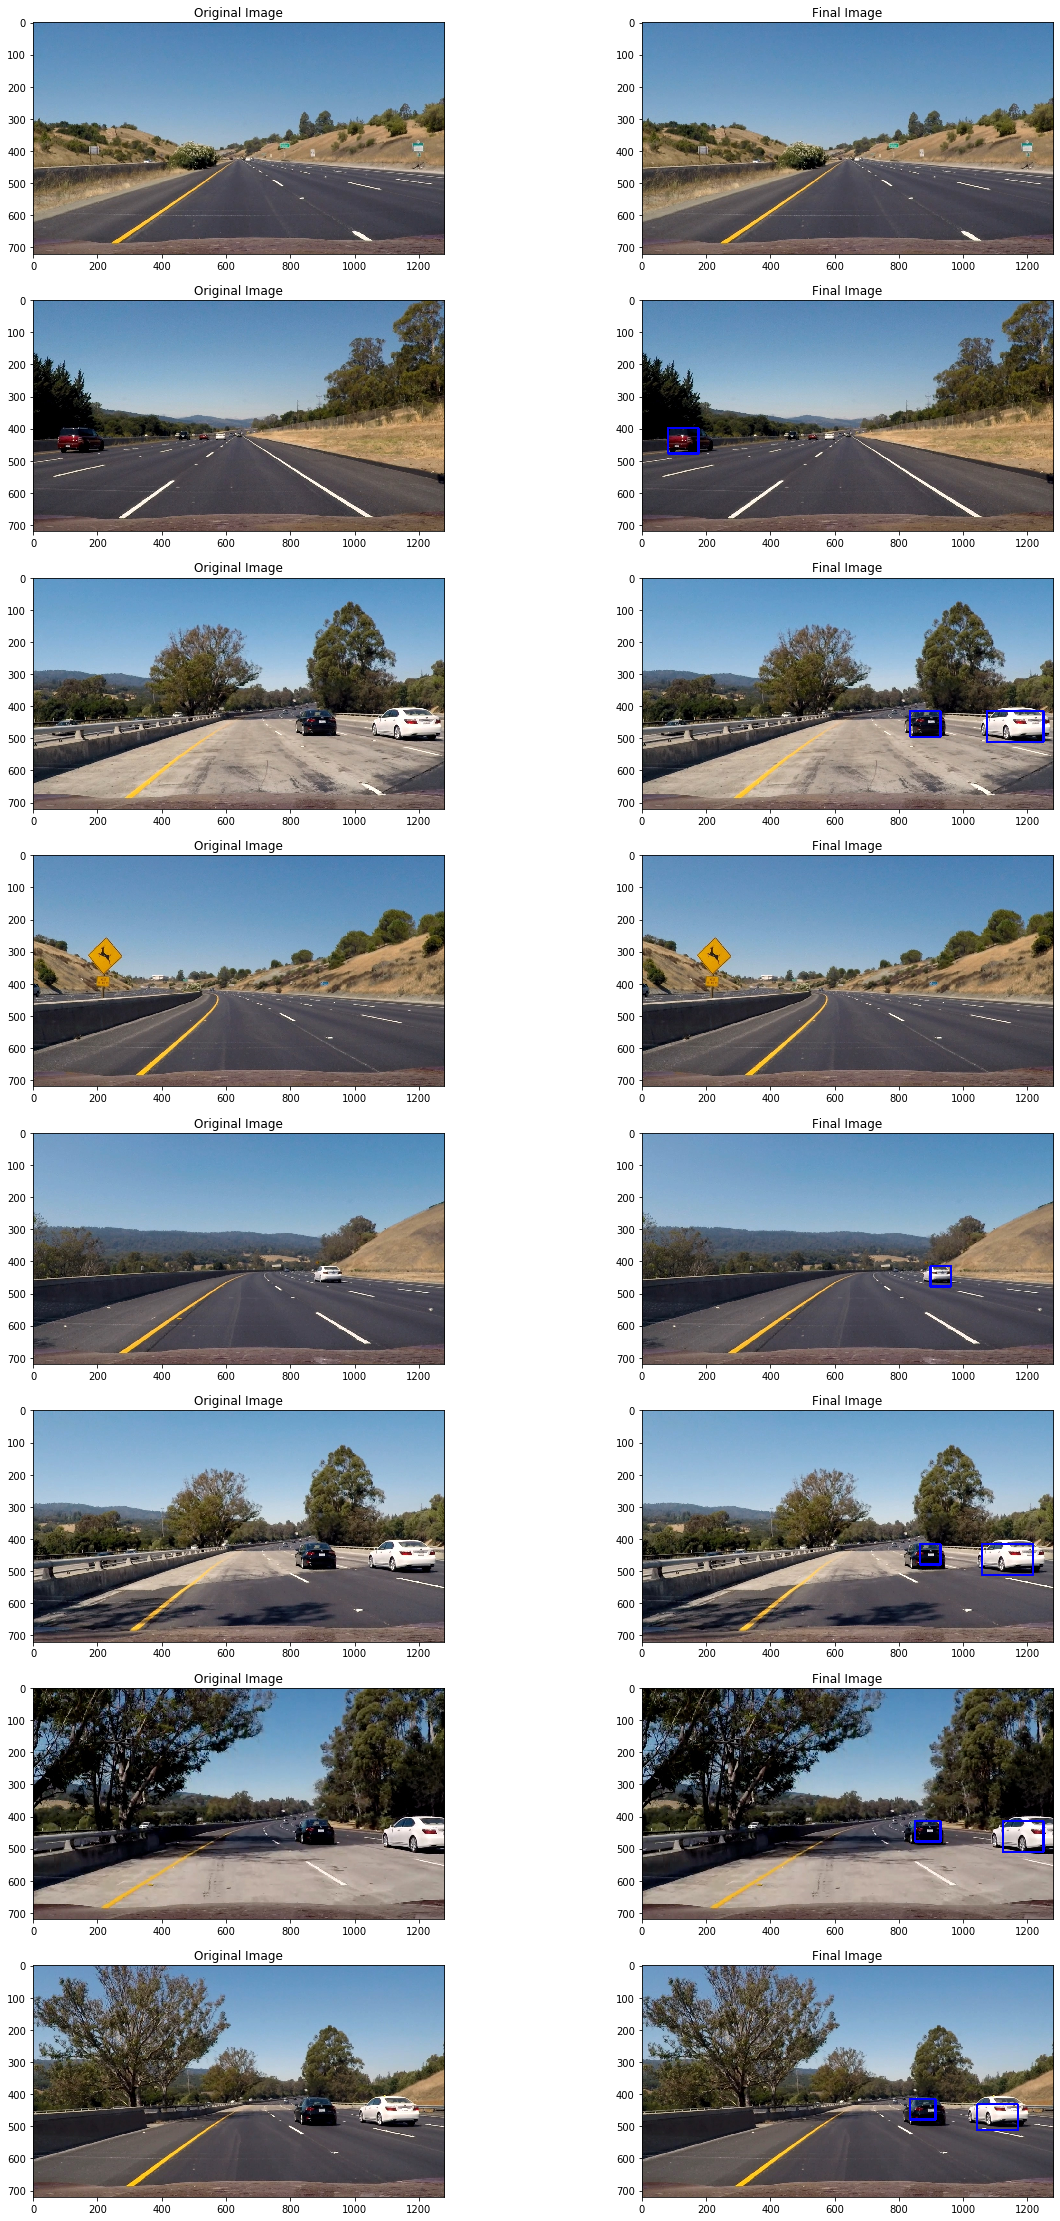

In [0]:
# Results from pipeline
test_images = glob.glob(data_dir + 'test_images/*.jpg')
print('Number of test images = ', len(test_images))
rows = len(test_images)
f, axes= plt.subplots(rows,2, figsize=(20,40))
t=time.time()
for index, image_path in enumerate(test_images):
    write_path = image_path.split('\\')[-1]
    image = read_image(image_path)
    finalPic = pipeline_find_cars(image)
    cv2.imwrite(data_dir+'output_images/result_'+ write_path, cv2.cvtColor(finalPic, cv2.COLOR_BGR2RGB))
    axes[index,0].imshow(image)
    axes[index,0].set_title("Original Image")
    axes[index,1].imshow(finalPic)
    axes[index,1].set_title("Final Image")
t2=time.time()
print('Time required = ', (t2-t))

In [0]:
import moviepy
from moviepy.editor import VideoFileClip
history_frames = 0
selector = 'project'
clip = VideoFileClip(data_dir + '{}_video.mp4'.format(selector)).fl_image(pipeline_find_cars)
clip.write_videofile(data_dir + '{}_video_result_{}.mp4'.format(selector, history_frames), audio=False)
clip.reader.close()
clip.audio.reader.close_proc()